# Parareal (with specifiable precision)

In this first experiment, we how a parareal integrator applied to the Lorenz system. The coarse integrator consists of RK4 with a single time step, the fine integrator consists of RK4 with ten intermediate time steps. The convergence rate (error as a function of iteration) is independent of the precision used

In [57]:
using LinearAlgebra, Plots

In [58]:
function Lorenz(::Type{T},t,u) where T<:AbstractFloat
    # Lorentz attractor. hard coding parameters in function.
    sigma = 10 # parameters for Lorenz
    r = 28 
    b = 8/3
    y1::T = sigma*(u[2]-u[1])
    y2::T = r*u[1]-u[2]-u[1]*u[3]
    y3::T = u[1]*u[2]-b*u[3]
   
    return [y1; y2 ; y3]
end

Lorenz (generic function with 1 method)

In [59]:
function rk4(::Type{T},f,tspan,u0,N) where T<:AbstractFloat
    # RK4 solve system of ODEs using the RK4 method
    #   [t,u]=Rk4(f,tspan,u0,N) solves du/dt=f(t,u) with initial
    #   value u0 on the time interval tspan doing N steps of RK4
    #   Returns the solution in time and space in the matrix u, and
    #   also the corresponding time points in the column vector t.    
    
    dt=(tspan[2]-tspan[1])/N
    t=tspan[1] .+ (0:N)*dt
    M = length(u0)
    u::Matrix{T} = zeros(M,N+1)
    u[:,1]=u0;
    for n=1:N
        tn = t[n]
        un = u[:,n]
        k1 = dt*f(T,tn,un)
        k2 = dt*f(T,tn+dt/2,un+k1/2)
        k3 = dt*f(T,tn+dt/2,un+k2/2)
        k4 = dt*f(T,tn+dt,un+k3)
        u[:,n+1] = un + 1/6*(k1+2*k2+2*k3+k4)
    end
    return t,u
end


rk4 (generic function with 1 method)

In [60]:
# lets solve sequentially using rk4, and use the solution as the true solution
tspan = [0 2]
u0 = [20; 5; -5]
Nt = 1800

texact, uexact = rk4(Float64,Lorenz, tspan, u0, Nt)
#=== uncommment if plot desired
plot(texact,uexact[1,:],label="x")
plot!(texact,uexact[2,:],label="y")
plot!(texact,uexact[3,:],label="z")
===#
uexact

3×1801 Matrix{Float64}:
 20.0  19.8383   19.6863   19.5438   …  -5.64066  -5.65542  -5.6704
  5.0   5.72293   6.43624   7.14003     -6.9592   -6.99393  -7.02885
 -5.0  -4.86671  -4.71901  -4.55732     21.2404   21.2212   21.2025

# Parareal: arbitrary (uniform) precision

In [61]:
function Parareal(::Type{T},F,G,Tf,u0,N,K) where T<:AbstractFloat
# implementation of the parareal algorithm
#   U=Parareal(F,G,T,u0,N,K); applies the parareal algorithm with fine
#   solver F(t0,t1,u0) and coarse solver G(t0,t1,u0) on [0,T] with
#   initial condition u0 at t=0 using N equidistant coarse time points
#   doing K iterations. The output U contains the parareal
#   approximations at the coarse time points for each iteration k.
    
    dT = Tf/N
    TT = (0:N)*dT
    M = length(u0)
    
    # we'll store the "shooting parameters"
    U::Array{T} = zeros(M,N+1,K+1)

    # k=0, n=0
    U[:,1,1] = u0   
    
    # coarse solve
    for n =1:N
        U[:,n+1,1] = G(T,TT[n],TT[n+1],U[:,n,1])
    end
    
    # corrections
    # note: you would organize loops differently to expose parallelism
    for k = 1:K
        U[:,1,k+1] = u0
        for n = 1:N
              U[:,n+1,k+1] = F(T,TT[n],TT[n+1],U[:,n,k]) +  G(T,TT[n],TT[n+1],U[:,n,k+1]) -  G(T,TT[n],TT[n+1],U[:,n,k])
        end
    end
    return TT, U
    
end
            

Parareal (generic function with 1 method)

In [32]:
# Wrap the RK4 function within a fine and coarse integrator: 
# coarse integrator will be one step of RK4, 
# fine integrator will be 10 steps
function F(::Type{T},t0,t1,u0) where T<:AbstractFloat
    t,u =  rk4(T,Lorenz,[t0 t1],u0,10)
    return u[:,end]
end

F (generic function with 1 method)

In [33]:
function G(::Type{T},t0,t1,u0) where T<:AbstractFloat
    t,u = rk4(T,Lorenz,[t0 t1],u0,1)
    return u[:,end]
end

G (generic function with 1 method)

# Parareal: double precision computation

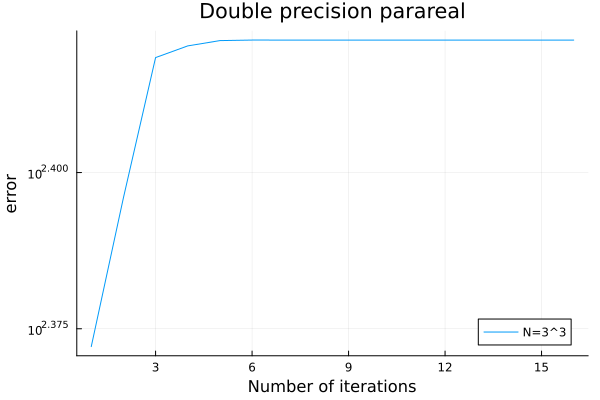

In [62]:
tspan = [0 10]
u0 = [20; 5; -5]
p = 3
#N = zeros(p)
N=180
#for i in 1:p
    #N[i] = Int(floor(2^(i+7)))
#end

KK = 15; # number of parareal iterations to plot
err_double = zeros(KK+1);
#for i in 1:p
    for K = 0:KK
        t, u = Parareal(Float64,F,G,tspan[2],u0, N, K)
        err_double[K+1] = norm(u[:,2:end,K+1]-uexact[:, 11:10:end])    

    end
#end

using Plots
plot(err_double, yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^3", title="Double precision parareal")
#for j in 2:p
    #plot!(err_double[:,j], yaxis=:log, xlabel="Number of iterations", ylabel="error", label="N=3^$(j+2)")
#end
#display(plot!(legend=:topright))

# Parareal - single precision

[ Info: Saved animation to /Users/sontoshsahani/Parareal-cloud/parareal.gif


Plots.AnimatedGif("/Users/sontoshsahani/Parareal-cloud/parareal.gif")
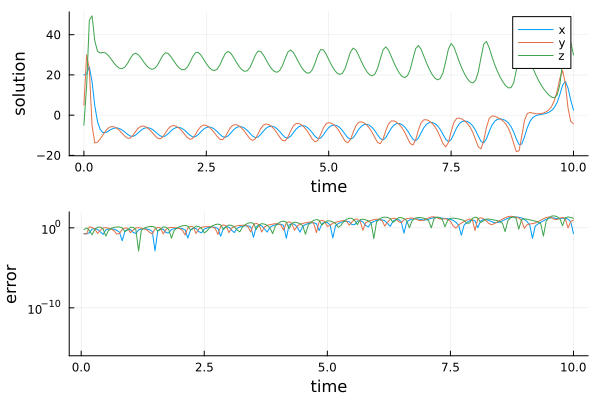

In [33]:
tspan = [0 Float32(10)]
u0 = [Float32(20); Float32(5); Float32(-5)]
N = 180

err_single = zeros(KK+1,1);

anim = @animate for K = 0:KK
t, u = Parareal(Float32,F,G,tspan[2],u0,N,K)

p1 = plot(t,u[1,:,K+1],label="x",xlabel="time",ylabel="solution")
p1 = plot!(t,u[2,:,K+1],label="y")
p1 = plot!(t,u[3,:,K+1],label="z")

p2 = plot(t[2:end],abs.(u[1,2:end,K+1]-uexact[1,11:10:end]).+eps(Float64),label="x",yaxis=:log,xlabel="time",ylabel="error",ylims=(1e-16,1e2),legend=false)
p2 = plot!(t[2:end],abs.(u[2,2:end,K+1]-uexact[2,11:10:end]).+eps(Float64),label="y")
p2 = plot!(t[2:end],abs.(u[3,2:end,K+1]-uexact[3,11:10:end]).+eps(Float64),label="z")
    
    err_single[K+1] = norm(u[:,2:end,K+1]-uexact[:,11:10:end])    
l = @layout [a ; b]
plot(p1,p2,layout = l)
end

current()
gif(anim, "parareal.gif", fps = 1)

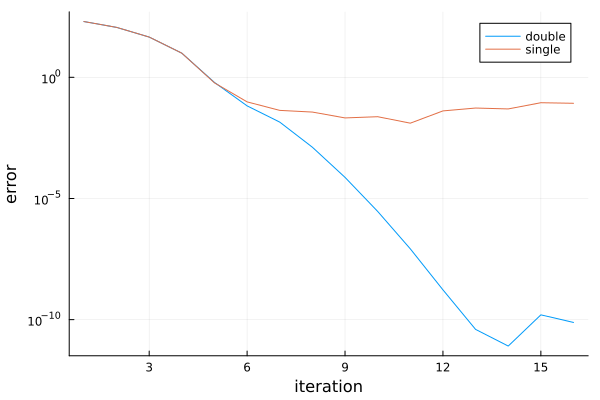

In [34]:
plot(1:KK+1,err_double,yaxis=:log,xlabel="iteration",ylabel="error",label="double")
plot!(1:KK+1,err_single,yaxis=:log,xlabel="iteration",ylabel="error",label="single")

# Mixed Precision
note: this is not the algorithm proposed in the paper. rather, this is a "naive" implementation where the coarse grid is computed using low precision

In [13]:
function MixedParareal(F,G,Tf,u0,N,K) 
# implementation of the parareal algorithm
#   U=Parareal(F,G,T,u0,N,K); applies the parareal algorithm with fine
#   solver F(t0,t1,u0) and coarse solver G(t0,t1,u0) on [0,T] with
#   initial condition u0 at t=0 using N equidistant coarse time points
#   doing K iterations. The output U contains the parareal
#   approximations at the coarse time points for each iteration k.
    
    dT = Tf/N
    TT = (0:N)*dT
    M = length(u0)
    
    # we'll store the "shooting parameters"
    U::Array{Float64} = zeros(M,N+1,K+1)

    # k=0, n=0
    U[:,1,1] = u0   
    
    # coarse solve
    for n =1:N
        U[:,n+1,1] = G(Float32,TT[n],TT[n+1],Float32.(U[:,n,1]))
    end
    
    # corrections
    # note: you would organize loops differently to expose parallelism
    for k = 1:K
        U[:,1,k+1] = u0
        for n = 1:N
              U[:,n+1,k+1] = F(Float64,TT[n],TT[n+1],U[:,n,k]) +                  
                Float32.(G(Float32,TT[n],TT[n+1],Float32.(U[:,n,k+1])) -  
                G(Float32,TT[n],TT[n+1],Float32.(U[:,n,k])))
        end
    end
    return TT, U
    
end

MixedParareal (generic function with 1 method)

[ Info: Saved animation to /Users/sontoshsahani/Parareal-cloud/parareal.gif


Plots.AnimatedGif("/Users/sontoshsahani/Parareal-cloud/parareal.gif")
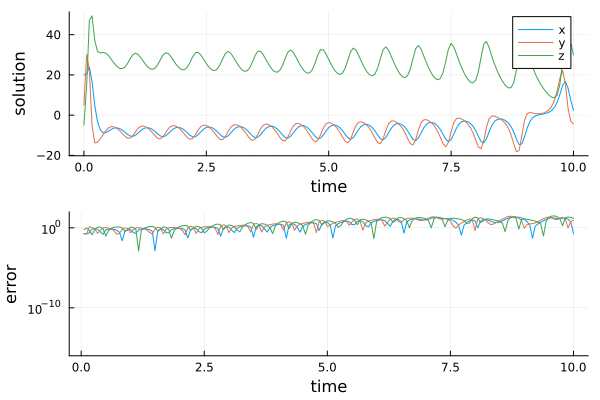

In [20]:
tspan = [0 10]
u0 = [20; 5; -5]
N = 180

err_mixed = zeros(KK+1,1);

anim = @animate for K = 0:KK
t, u = MixedParareal(F,G,tspan[2],u0,N,K)

p1 = plot(t,u[1,:,K+1],label="x",xlabel="time",ylabel="solution")
p1 = plot!(t,u[2,:,K+1],label="y")
p1 = plot!(t,u[3,:,K+1],label="z")

p2 = plot(t[2:end],abs.(u[1,2:end,K+1]-uexact[1,11:10:end]).+eps(Float64),label="x",yaxis=:log,xlabel="time",ylabel="error",ylims=(1e-16,1e2),legend=false)
p2 = plot!(t[2:end],abs.(u[2,2:end,K+1]-uexact[2,11:10:end]).+eps(Float64),label="y")
p2 = plot!(t[2:end],abs.(u[3,2:end,K+1]-uexact[3,11:10:end]).+eps(Float64),label="z")
    
    err_mixed[K+1] = norm(u[:,2:end,K+1]-uexact[:,11:10:end])    
l = @layout [a ; b]
plot(p1,p2,layout = l)
end

current()
gif(anim, "parareal.gif", fps = 1)

In [21]:
plot(1:KK+1,err_double,yaxis=:log,xlabel="iteration",ylabel="error",label="double")
plot!(1:KK+1,err_single,yaxis=:log,xlabel="iteration",ylabel="error",label="single")
plot!(1:KK+1,err_mixed,yaxis=:log,xlabel="iteration",ylabel="error",label="mixed")


LoadError: Expects 41 elements in each col of y, found 40.

kinda expected: convergence rate stays the same for single, mixed or double precision, but mixed precision computation error is poluted by low-precision bits. 

# Paper Replication (ish -  BE for both predictor and corrector)
simplifying to dalhquist, BE, and parareal-type algorithm in manuscript.

In [16]:
function be_Dahlquist(::Type{T},tspan,u0,N,lambda) where T<:AbstractFloat
    # solve dahlquist equation using be
    #   [t,u]=be_dahlquist(typem f,tspan,u0,N) solves du/dt=lambda*u with initial
    #   value u0 on the time interval tspan doing N steps of BE
    
    dt=(tspan[2]-tspan[1])/N
    y::T = u0
    
    for n = 1:N
        y = y / (1 - lambda * dt)
    end
    return y
end

# Wrap the BE function within a fine and coarse integrator: 
# coarse integrator will be one step of BE, 
# fine integrator will be 10 steps of BE
# overloading function F and G, provided an extra parameter lambda is given
function F(::Type{T},t0,t1,u0,lambda) where T<:AbstractFloat
    u =  be_Dahlquist(T,[t0 t1],u0,10,lambda)
    return u
end

function G(::Type{T},t0,t1,u0,lambda) where T<:AbstractFloat
    u =  be_Dahlquist(T,[t0 t1],u0,1,lambda)
    return u
end

function ModifiedMixedParareal(F,G,Tf,u0,N,K,lambda) 
# implementation of the parareal algorithm
#   U=ModifiedMixedParareal(F,G,T,u0,N,K,lambda); applies the parareal algorithm with fine
#   solver F(t0,t1,u0) and coarse solver G(t0,t1,u0) on [0,T] with
#   initial condition u0 at t=0 using N equidistant coarse time points
#   doing K iterations. The output U contains the parareal
#   approximations at the coarse time points for each iteration k.
# note the Float64 and Float32 definitions floating throughout algorithm
    
    dT = Tf/N
    TT = (0:N)*dT
    
    # we'll store the "shooting parameters"
    U::Array{Float64} = zeros(N+1,K+1)
    delta::Array{Float32} = zeros(N+1,K+1)
    d::Array{Float32} = zeros(N+1,K+1)
    
    # k=0, n=0
    U[1,1] = u0   
       
    # coarse solve (or can generate random initial guess as in paper)
    for n =1:N
        # U[n+1,1] = G(Float32,TT[n],TT[n+1],Float32.(U[n,1]),lambda)
        U[n+1,1] = u0
    end
    
    # corrections
    # note: you would organize loops differently to expose parallelism
    for k = 1:K
            
        # step 1: fine solve            
        U[1,k+1] = u0
        for n = 1:N
            U[n+1,k+1] = F(Float64,TT[n],TT[n+1],U[n,k],lambda)
        end
 
        #step 2: sequential corrections
        for n = 1:N
            delta[n+1,k+1] = Float32.( U[n+1,k+1] - U[n+1,k]) 
        end    
        for n = 1:N
            d[n+1,k+1] = G(Float32,TT[n],TT[n+1],delta[n,k],lambda)
        end            
        for n = 1:N
            U[n+1,k+1] = U[n+1,k+1] + Float64.(d[n+1,k+1])
        end   
    end
    return TT, U
    
end # ModifiedMixedParareal

function ModifiedSingleParareal(F,G,Tf,u0,N,K,lambda) 
# implementation of the parareal algorithm
#   U=ModifiedMixedParareal(F,G,T,u0,N,K,lambda); applies the parareal algorithm with fine
#   solver F(t0,t1,u0) and coarse solver G(t0,t1,u0) on [0,T] with
#   initial condition u0 at t=0 using N equidistant coarse time points
#   doing K iterations. The output U contains the parareal
#   approximations at the coarse time points for each iteration k.
# note the Float32 definitions floating throughout algorithm    
    
    dT = Tf/N
    TT = (0:N)*dT
    
    # we'll store the "shooting parameters"
    U::Array{Float32} = zeros(N+1,K+1)
    delta::Array{Float32} = zeros(N+1,K+1)
    d::Array{Float32} = zeros(N+1,K+1)
    
    # k=0, n=0
    U[1,1] = u0   
       
    # coarse solve (or can generate random initial guess as in paper)
    for n =1:N
    #    U[n+1,1] = G(Float32,TT[n],TT[n+1],Float32.(U[n,1]),lambda)
        U[n+1,1] = u0
    end
    
    # corrections
    # note: you would organize loops differently to expose parallelism
    for k = 1:K
            
        # step 1: fine solve            
        U[1,k+1] = u0
        for n = 1:N
            U[n+1,k+1] = F(Float32,TT[n],TT[n+1],U[n,k],lambda)
        end
 
        #step 2: sequential corrections
        for n = 1:N
            delta[n+1,k+1] = Float32.( U[n+1,k+1] - U[n+1,k]) 
        end    
        for n = 1:N
            d[n+1,k+1] = G(Float32,TT[n],TT[n+1],delta[n,k],lambda)
        end            
        for n = 1:N
            U[n+1,k+1] = U[n+1,k+1] + Float32.(d[n+1,k+1])
        end   
    end
    return TT, U
    
end # ModifiedSingleParareal

function ModifiedDoubleParareal(F,G,Tf,u0,N,K,lambda) 
# implementation of the parareal algorithm
#   U=ModifiedMixedParareal(F,G,T,u0,N,K,lambda); applies the parareal algorithm with fine
#   solver F(t0,t1,u0) and coarse solver G(t0,t1,u0) on [0,T] with
#   initial condition u0 at t=0 using N equidistant coarse time points
#   doing K iterations. The output U contains the parareal
#   approximations at the coarse time points for each iteration k.
# note the Float64 efinitions floating throughout algorithm    
    
    dT = Tf/N
    TT = (0:N)*dT
    
    # we'll store the "shooting parameters"
    U::Array{Float64} = zeros(N+1,K+1)
    delta::Array{Float64} = zeros(N+1,K+1)
    d::Array{Float64} = zeros(N+1,K+1)
    
    # k=0, n=0
    U[1,1] = u0   
       
    # coarse solve (or can generate random initial guess as in paper)
    for n =1:N
        #U[n+1,1] = G(Float64,TT[n],TT[n+1],Float64.(U[n,1]),lambda)
        U[n+1,1] = u0      
    end
    
    # corrections
    # note: you would organize loops differently to expose parallelism
    for k = 1:K
            
        # step 1: fine solve            
        U[1,k+1] = u0
        for n = 1:N
            U[n+1,k+1] = F(Float64,TT[n],TT[n+1],U[n,k],lambda)
        end
 
        #step 2: sequential corrections
        for n = 1:N
            delta[n+1,k+1] = Float64.( U[n+1,k+1] - U[n+1,k]) 
        end    
        for n = 1:N
            d[n+1,k+1] = G(Float64,TT[n],TT[n+1],delta[n,k],lambda)
        end            
        for n = 1:N
            U[n+1,k+1] = U[n+1,k+1] + Float64.(d[n+1,k+1])
        end   
    end
    return TT, U
    
end # ModifiedDoubleParareal

ModifiedDoubleParareal (generic function with 1 method)

In [17]:
tspan = [0 0.5]
u0 = 1.0
N = 10000
KK = 40 

err_mixed = zeros(KK,1);
err_single = zeros(KK,1);
err_double = zeros(KK,1);
lambda = -0.02  # note: lambda*dT = 1e-4, same as paper

for K = 1:KK
    t, u = ModifiedMixedParareal(F,G,tspan[2],u0,N,K,lambda)
    err_mixed[K] = norm(u[end,K+1]-u0*exp(lambda*tspan[2]))    
    
    t, u = ModifiedSingleParareal(F,G,tspan[2],u0,N,K,lambda)
    err_single[K] = norm(u[end,K+1]-u0*exp(lambda*tspan[2]))    
    
    t, u = ModifiedDoubleParareal(F,G,tspan[2],u0,N,K,lambda)
    err_double[K] = norm(u[end,K+1]-u0*exp(lambda*tspan[2]))    
end



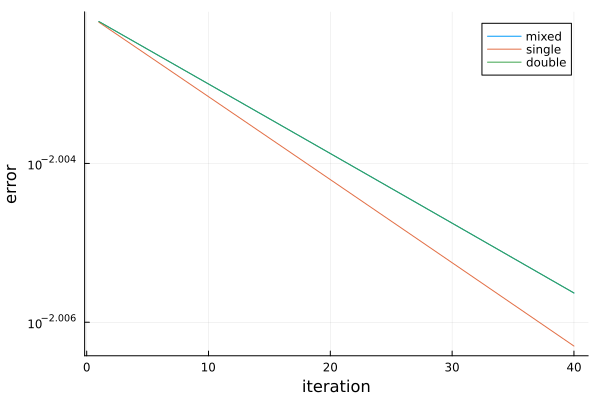

In [18]:
plot(1:KK,err_mixed,yaxis=:log,xlabel="iteration",ylabel="error",label="mixed")
plot!(1:KK,err_single,yaxis=:log,xlabel="iteration",ylabel="error",label="single")
plot!(1:KK,err_double,yaxis=:log,xlabel="iteration",ylabel="error",label="double")

My simplified mixed-precision parareal algorithm (presented in paper) does not converge as expected. Code is simple enough that I don't believe there is a bug. Some differences
- I,m using a coarse grid rather than random initial guesses
- I'm using BE with different time steps for the coarse and fine integrator, rather than BE + TR/BDF2 in paper
- this is my interpretation of Algorithm 2.1

In [19]:
err_mixed

40×1 Matrix{Float64}:
 0.009949166251381314
 0.009947166254524742
 0.00994516626069153
 0.009943166270790949
 0.009941166284936687
 0.009939166303015279
 0.009937166325139968
 0.009935166351311198
 0.009933166381414837
 0.009931166415564907
 0.00992916645364772
 0.00992716649577663
 0.00992516654195208
 ⋮
 0.009893167823778026
 0.009891167937944423
 0.00988916805604323
 0.009887168178188466
 0.009885168304266223
 0.009883168434390077
 0.009881168568560361
 0.009879168706663166
 0.009877168848811957
 0.00987516899489349
 0.009873169145021343
 0.009871169299081384